<a href="https://colab.research.google.com/github/rubanzasilva/fastAiProjects/blob/main/AntelopeClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Antelope Classification model - Introduction

Anyone who has travelled to Uganda will know that it is blessed with rich ecosystem that accommodates various kinds of species of Animals.

On a recent drive through Queen Elizabeth national park in Katungulu, I happened to spot a number of what seemed to be antelopes inspiring me to create this antelope classifier


Following a pattern of sorts from fastai tutor tanishq's [dogs vs cats blog](https://www.tanishq.ai/blog/gradio_hf_spaces_tutorial) post, I decided to build and blog about something similar where i deploy an antelope classifier model to hugging face spaces and build a web interface with gradio.
The antelope dataset used to train the model is scrapped from duck duck go.

With this we provide a prediction of the label showing which class the antelope belongs to and it’s corresponding confidence.


After you train a model, Various people from software enginners, business people etc will need to use the results from your model in order to drive business value, inform decision making etc.

If you want people to interact with your model outside of a juypter notebook will need to deploy your model to a web application building a UI on top of the model that can anyone can interact with.

To do the above, we host our model on Hugging face Spaces and we use gradio to build a web interface for the model but first we start with prequisites i.e. data collection and building the model.

### Imports
Import fastbook which sets up all the dependencies youll need to complete this notebook.
If you run the notebook in google colab.This code cell mounts google drive in colab

In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

#hide
from fastbook import *
from fastai.vision.widgets import *

Gradio dependencies

Note that i use `#|` which is an nbdev trick that later enables us export the code in those cells into a general `.py` file.

We declare a default export at the top with the ".py" file being named **app.py**

In [ ]:
#|default_exp app

In [ ]:
#|export

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [ ]:
!pip install gradio==3.0
# !pip install bentoml
!pip install nbdev

In [ ]:
#|export
from fastai.vision.all import *
import gradio as gr

## Data collection
For any machine learning project, one of the most important and starting points is the data.
For the above classification task, We search and scrape the web using duck duck go for images of antelopes. Duck duck go currently doesnt require any API keys to pull images from the web.


In the cell below, we search duck duck go for one image, download it then display just to test our scraping functionality

In [2]:
urls = search_images_ddg('Uganda Kob', max_images=1)
urls[0]

'https://live.staticflickr.com/8645/16478715988_a2da1a64bf_b.jpg'

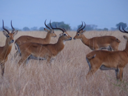

In [4]:
#| label: fig-kob-preview
#| fig-cap: Preview of downloaded image 
dest = 'images/ugandaKob.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(128,128)

Above is a preview of the image we just downloaded resized to 128 x 128 px.
All images are converted into a tensor then fed to the dataloaders.
Images are passed to a dataloader as tensors, hence they are all converted to tensor and must be the same size.
To ensure this, We always apply the same transformations across all images.

**Define search terms**

Define search terms that our chosen search engine will search for.
A path where the downloads will be stored is defined.
In this case, we shall be searching for images with the defined search terms for types of antelopes below

In [5]:
#search terms and path
#search times should be on one line
antelope_types = 'Eland', 'Greater Kudu', 'Hartebeest', 'Oryx', 'Defassa Waterbuck', 'Sitatunga', 'Impala ', 'The lesser Kudu', 'Grant’s Gazelle', 'Reedbuck', 'Uganda Kob','Forest duiker','Harvery’s red duiker', 'Blue duiker', 'Peter’s duiker','Black fronted duiker','Grey duiker','Oribi','Klipspringer','Guenther’s dik dik', 'Bates’s pygmy','sable', 'roan', 'nyala', 'bushbuck', 'tsessebe', 'steenbok'
path = Path('antelope')


In [6]:
from time import sleep

for o in antelope_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f'{o} antelope'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images_ddg(f'{o} antelopes in a herd'))
    sleep(10)
    # download_images(dest, urls=search_images_ddg(f'{o} antelope low resolution images'))
    # sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:1038: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
#Navigate to image directory to check out downloaded images
!ls antelope/Oryx

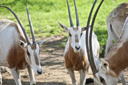

In [11]:
#| label: fig-dataset-preview
#| fig-cap: Preview of image from our downloaded dataset 
im = Image.open('antelope/Oryx/cd706adb-85df-4883-af3f-cd7416e04b54.jpg')
im.to_thumb(128,128)

Remove failed images
Some of the images downloaded are incorrect etc.
We use a verify_images function to iterate through our downloaded dataset, check for corrupt images ( by finding the images that cant open ) and remove the failed links

In [12]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

173

## Define datablock and build model





###DataBlock
We need to put the data in a format that can be used to train our models by creating a ***dataloader*** object.
A datablock API helps us customize our dataloaders object by telling fastai the four things we need to define a dataloaders class.


*   The type of data we are working with ( blocks )
*   How to get the list of items ( get_items )
*   How to label these items ( get_y )
*   How to create a validation set ( splitter )

In [13]:
antelopes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [14]:
dls = antelopes.dataloaders(path)

Dataloaders class provides images for processing in batches of a few items at a go.
Below is an example of such a batch i.e batch of 64 ( the default ) gives you 64 items at a time.

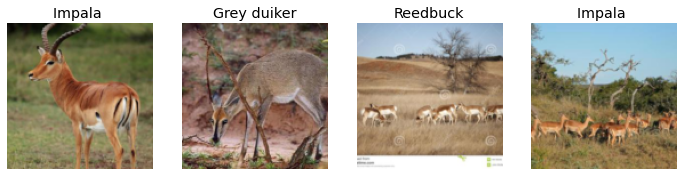

In [15]:
#| label: fig-batch-processing
#| fig-cap: A batch of images 
dls.valid.show_batch(max_n=4, nrows=1)

### Data Augmentation

**Data augmentation** refers to creating random variations of the input data such that it appears different without actually changing the fundmental meaning of the data for example flipping, perspective warping, brigtnes and contrast variations.

Fastai provides us with an `aug_transforms` function which provides us with a set of standard augmentations that have been found to work pretty well.

We apply these transforms to the entire batch using the `batch_tfms` parameter.

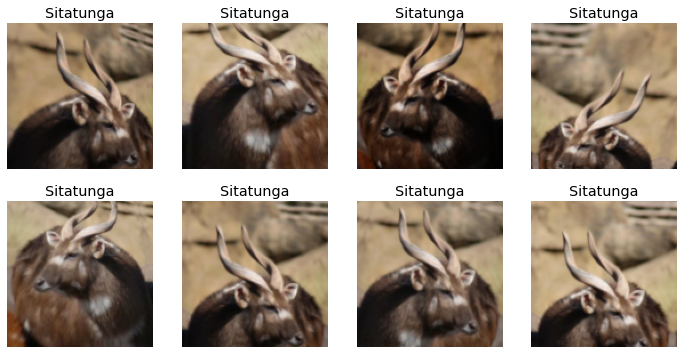

In [16]:
antelopes = antelopes.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = antelopes.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Now that we have assembled our data in a format fit for model training, let's actually train an image classifier using it.

In [18]:
antelopes = antelopes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = antelopes.dataloaders(path)

## Define learner, Train your model, and use it to clean your data

###Learner

In [19]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0010000000474974513)

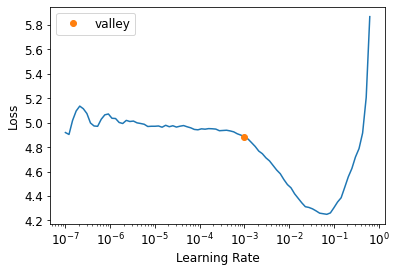

In [20]:
learn.lr_find()

###Train model
In this case, we are fine-tuning a pre-trained resnet model.

In [21]:
learn.fine_tune(30, 0.0010000000474974513 ,wd=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,3.372276,2.143574,0.570588,00:53


epoch,train_loss,valid_loss,error_rate,time
0,2.578591,1.985760,0.532353,00:58
1,2.327583,1.872143,0.502941,00:58
2,2.165941,1.765570,0.474020,00:57
3,2.038731,1.699078,0.457843,00:59
4,1.898295,1.627997,0.458333,00:56
5,1.762177,1.545428,0.429902,00:58
6,1.646199,1.508349,0.426471,00:59
7,1.503344,1.478068,0.415196,01:09
8,1.421756,1.463436,0.413725,00:57


epoch,train_loss,valid_loss,error_rate,time
0,2.578591,1.985760,0.532353,00:58
1,2.327583,1.872143,0.502941,00:58
2,2.165941,1.765570,0.474020,00:57
3,2.038731,1.699078,0.457843,00:59
4,1.898295,1.627997,0.458333,00:56
5,1.762177,1.545428,0.429902,00:58
6,1.646199,1.508349,0.426471,00:59
7,1.503344,1.478068,0.415196,01:09
8,1.421756,1.463436,0.413725,00:57
9,1.290716,1.423412,0.407843,00:59


###Visualize results with Confusion Matrix

Fastai allows us to see the results of our model using a confusion matrix.For example if we want to see how many antelopes are being classified correctly vs incorreclty.

The rows represent the actual labels of the antelopes in the dataset plotted against the resulting predictions from the model in the columns.

The values in the diagonal represent the correctly classfied while the off- diagonal values represent the incorrectly classified images.




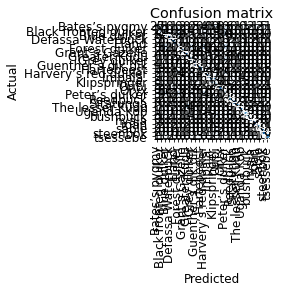

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Top losses
We plot our images based off loss starting from the top loss.

This helps us look at the images with the highest loss and we try to look for patterns to theorize whats causing this.
Here we actually get to see the image, its prediction, actual label, loss and probability that the model is correct.

A high loss results from high model confidence in a misclassfied image or low confidence in a correclty classified image.
This can result from issues in the dataset, the model or both.

Plot images according to losses helps us when doing data cleaning as shown below

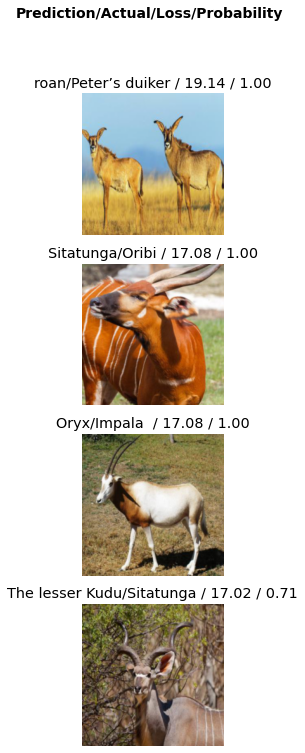

In [27]:
interp.plot_top_losses(4, nrows=4)

### Data cleaning with fastai ImageClassifierCleaner

As unintuitive as it seems, training a model before data cleaning can help us identify where some of the issues in our dataset which speeds up our data cleaning process.

Fastai has a GUI tool that enables to view our input data from either training or validation.
Furthermore it enables us to delete, re-label and clean our data in various ways.
This GUI also sorts images based off loss enabling us to edit the images giving our model issues first.

In [28]:
#hide_output
#images are ordered by loss/confidence
cleaner = ImageClassifierCleaner(learn)
cleaner

The actual functions that execute above chosen tasks i.e. deleting or re-labelling

In [ ]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Export Model
You have to export your model so that you can use the model for inference outside of this session.

We use the export method for this. This saves the model architecture, parameters and the definition of how we created our data loaders which defines the transforms to be performed on the dataset etc.

In [29]:
learn.export('antelopeClassifier.pkl')

Let's check that the file exists, by using the `ls` method that fastai adds to Python's `Path` class:

In [30]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('antelopeClassifier.pkl')]

## Turning Your Model into an Online Application

Now we know how to save and export the model, load it and use it for inference.
In the same parent folder, we create another .ipynb file where we load our saved model, define a fuction to do inference, and create a web interface for it using gradio.

The model is uploaded and served via Hugging face spaces.

Terminate this session, and navigate to the parent directory, open antelopeInference.ipynb and run the cells



# East African Antelope Classifier Model Deployment
## Hugging face Spaces + Gradio

This part can be run outside of this current notebook all you would have to do is load the model.

As mentioned above, to enable people interact with our model outside of Jupyter notebook, we deploy the model to the cloud and build a UI on top of that.

To do the above, we host our model on Hugging face Spaces and we use gradio to build a web interface for the model.

This lets other people interact with the underlying model through a decent UI.

In my experience, this part is just as important as any other parts of the whole lifecylce.

In this example, we deploy a model that classifies East african antelopes into categories and gives a score based on confidence.



### Using the Model for Inference

We use the load_learner method to load a the model that was trained and exported as a pickle object above.
In this case, we already have our model loaded hence no need to call load_learner in this same session.

In [ ]:
#hide
learn_inf = load_learner(path/'bearClassifier.pkl')

Pass a filename of a sample image to the predict method to do inference on that image.

In [ ]:
!ls sample_data/

anscombe.json		      IMG_9890.jpeg	     README.md
california_housing_test.csv   mnist_test.csv
california_housing_train.csv  mnist_train_small.csv


In [ ]:
learn.predict('sample_data/IMG_9890.jpeg')

#we would have used this incase we had used the above load_learner method
#learn_inf.predict('images/grizzly.jpg')

('Reedbuck',
 TensorBase(7),
 TensorBase([0.0163, 0.0047, 0.2014, 0.2379, 0.0038, 0.0147, 0.0654, 0.3663, 0.0120, 0.0640, 0.0136]))

This returns the predicted category, 

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:

In [ ]:
learn.dls.vocab

['Defassa Waterbuck', 'Eland', 'Grant’s Gazelle', 'Greater Kudu', 'Hartebeest', 'Impala ', 'Oryx', 'Reedbuck', 'Sitatunga', 'The lesser Kudu', 'Uganda Kob']

##Upload model to Hugging Face Spaces

[Hugging Face Spaces](https://huggingface.co/spaces) is a platform that offers git repositories where we can store and host code for Machine Learning apps and demos.
In this example, we take our antelope classifier model and upload it to hugging face spaces server.

Spaces also offers us ways to build a UI ontop of this model using frameworks such as streamlit, gradio or with docker images.

In this example, we shall use gradio to build our interface.

Hugging face requires us to have an account before using spaces.If you have one, log in if not create one.

After logging in, navigate to the spaces main page by following the link above or clicking spaces on the navbar.

Click `Create new Space`.

Give the space a name, in this example we named it **bearClassifierInference**.
Choose a license, I used apache-2.0 as it has the most basic terms and allows it to be reused without me doing anything.

I choose gradio for SDK as thats what i will be using in this particular example to build my UI.

Make it public to enable sharing.

Then Click `Create Space`.

### Potential Issues

[link text](https://)In the image i took of my phone, i can actually see what appears to be more than one class of antelopes.
Hence since an image is classifying the image as a whole, results might be based of one class only.

##Acknowledgments
Jeremy Howard and the fast.ai community
Tanishq
